In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

import time

<h1>Prepare training data</h1>

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./test_data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./test_data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████▉| 170450944/170498071 [06:31<00:00, 715265.90it/s]

Files already downloaded and verified


170500096it [06:50, 715265.90it/s]                                                                                     

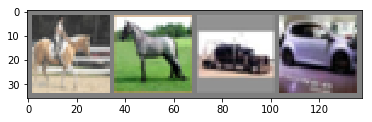

horse horse truck   car


In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# take some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<h1>Neural Network</h1>

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

<h3>Loss Function</h3>

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

<h3>Network Training</h3>

In [15]:
start = time.time()

for epoch in range(2):  # loops over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

end = time.time()            
            
print('Finished training in %.2d seconds' % (end - start))

[1,  2000] loss: 1.035
[1,  4000] loss: 1.044
[1,  6000] loss: 1.066
[1,  8000] loss: 1.059
[1, 10000] loss: 1.032
[1, 12000] loss: 1.066
[2,  2000] loss: 0.949
[2,  4000] loss: 0.982
[2,  6000] loss: 1.016
[2,  8000] loss: 1.018
[2, 10000] loss: 0.998
[2, 12000] loss: 1.004
Finished training in 169 seconds


 <h3>Testing the network</h3>

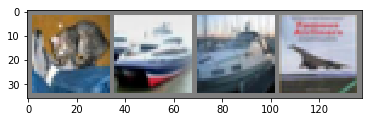

GroundTruth:    cat  ship  ship plane


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 76 %
Accuracy of  bird : 52 %
Accuracy of   cat : 50 %
Accuracy of  deer : 52 %
Accuracy of   dog : 46 %
Accuracy of  frog : 66 %
Accuracy of horse : 64 %
Accuracy of  ship : 78 %
Accuracy of truck : 63 %


<h1>For training on GPU</h1>

In [ ]:
# just like with sending tensors to the GPU, you need to send the NN to the GPU
# as well.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

# after that, you need to send to inputs and targets to the GPU.
inputs, labels = inputs.to(device), labels.to(device)

# you will only notice a difference in speed on larget networks however.

<h1>Save/Load</h1>
<h3>Models</h3>

In [ ]:
# to save:
torch.save(model.state_dict(), PATH)

# to load
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

<h3>Checkpoints during training</h3>

In [ ]:
# to save:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)

# to load:
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()